# Numerical solution to the time-dependent Schroedinger equation: A direct method

So far, we have only solved ordinary differential equations of the form 

$$\frac{d^nx}{dt^n} = f(x)$$

But what if we want to do some quantum mechanics in the computer? After all, in your QM course you solve the particle in a box, the harmonic oscillator, the hydrogen atom, the He atom (approximately), and then some simple problems that can be handled by perturbation theory. What about everything else? 

Recall the form of the time-dependent Schroedinger equation:

$$i\hbar\frac{\partial\psi(x,t)}{\partial t} = \frac{-\hbar^2}{2m}\nabla^2\psi(x,t) + V\psi(x,t) \tag{1}$$

Now we have to numerically integrate an equation with derivatives in *both* space *and* time. We need a spatial grid as well as a discretized time axis. Once you carry out the normalization, the Schrodinger equation becomes:

$$\frac{\partial\psi(x,t)}{\partial t} = \frac{i}{2}\nabla^2\psi(x,t) -iV\psi(x,t) \tag{2}$$

We will use $i$ to index the timestep and $n$ to index the spatial grid. We therefore seek numerical solutions that give us $\psi(x_n, t_i)$ --- the wavefunction defined on discrete gridpoints and evaluated at successive times, separated as before by a timestep $\delta t$. My crappy figure illustrates the spatial variation of the wavefunction at two timesteps, discretized on a grid with a resolution $\Delta x$. <img src="./discretized_wave_packet.png" alt="drawing" width="400"/>

In addition to choosing a sensible timestep, it is also now necessary to choose a sensible resolution for the spatial grid. 

# Solving for the spatial dependence at fixed time

Consider a particular time $t_i$. How do we handle the $\nabla^2$ on the R.H.S. of the S.E.? A simple finite difference scheme works, with a small trick. The first derivative is

$$\frac{\partial\psi(x_{n+1/2}, t_i)}{\partial x} \approx \frac{\psi(x_{n+1},t_i) - \psi(x_{n},t_i)}{\Delta x} \tag{3}$$

We use an expression for the half-grid point for the first derivative, because the second order finite difference expression gives us the on-grid value:

$$\begin{align}
\frac{\partial\psi^2(x_{n}, t_i)}{\partial x^2} &= \frac{\partial\psi(x_{n+1/2}, t_i)/ \partial x - \partial\psi(x_{n-1/2}, t_i)/\partial x}{\Delta x}\\
&= \frac{\psi(x_{n+1},t_i) - \psi(x_{n},t_i) - (\psi(x_{n},t_i) - \psi(x_{n-1},t_i))}{\Delta x^2}\\
&= \frac{\psi(x_{n+1},t_i) - 2\psi(x_{n},t_i) + \psi(x_{n-1},t_i)}{\Delta x^2} \tag{4}
\end{align}$$

# Updating the time-dependence: Stability problem

Let's consider using a simple Euler method to evolve our wavefunction in time. This would look like (setting $V=0$) for simplicity:

$$\begin{align}
\psi(x_n,t_{i+1}) & = \psi(x_n,t_{i}) + \Delta t \frac{\partial \psi}{\partial t} \\
& = \psi(x_n,t_{i}) + \Delta t \left[\hat{H}\psi(x_n,t_{i})\right] \\
& = \psi(x_n,t_{i}) + \Delta t\left[ \frac{i}{2}\frac{\partial^2\psi(x_n,t_{i})}{\partial x^2} \right] \\
& =  \psi(x_n,t_{i}) + \frac{i\Delta t}{2\Delta x^2}\left( \psi(x_{n+1},t_i) - 2\psi(x_n,t_i) + \psi(x_{n-1},t_i) \right)\tag{5}\\
\end{align}$$

Is this stable? To answer this question we will write the solution to the S.E. as a sum of Fourier modes, and consider how the *amplitudes* of those modes evolve under the Euler integration. 

The wavefunction at any time $t_i$ can be written in the Fourier domain as follows:

$$\psi(x_n,t_i) = \sum_{k}A_k(t_i)e^{ikn\Delta x} \tag{6}$$ 

All the time dependence is in the amplitudes, and so we can consider the time-evolution under Euler of a single mode and that suffices for all of them. 

To find the time-dependence of the amplitudes, we substitute Eq. 6 into Eq. 5 to obtain (letting $D=\Delta t/2\Delta x^2$ to simplify the notation):

$$A_k(t_{i+1})e^{ikn\Delta x} = A_k(t_i)e^{ikn\Delta x} + iDe^{ikn\Delta x}\left(e^{ik\Delta x} - 2 + e^{-ik\Delta x} \right) \tag{7}$$

The ratio of $A$ at successive timesteps tells us whether it is growing or not:

$$\frac{A_k(t_{i+1})}{A_k(t_i)} = 1 + iD(2\cos(k\Delta x) -2) \tag{8}$$

If $|A_k(t_{i+1})/A_k(t_{i})| > 1$, our amplitudes all grow in time, the normalization is not preserved (evolution in time is not unitary), and the solution is unstable:

$$\begin{align}
\left| \frac{A_k(t_{i+1})}{A_k(t_i)}\right| & = (1 + iD(2\cos(k\Delta x) -2))(1 - iD(2\cos(k\Delta x) -2))\\
& = 1+4D^2(\cos(k\Delta x) -1)^2 \\
\end{align}$$

Not stable!


# Updating spatial dependence, Re and Im parts with leapfrog

The stability and unitarity problem can be solved by integrating the Re and Im parts of the wavefunction at staggered timesteps, in a "leapfrog" fashion. Recall that the wavefunction is a complex function, with real and imaginary parts. In the computer this is a straightforward complication to manage --- we just treat it using the Cartesian representation: $z = x + iy$, and update the Re and Im parts spearately. Consider:

$$\psi(x,y) = R(x,t) + iI(x,t)$$

where $R$ is the real part of $\psi$ and $I$ the imaginary part. Substituting this representation into Eq. 2:

$$\begin{align}
\frac{\partial R}{\partial t} &= \left(-\frac{1}{2}\frac{\partial^2}{\partial x^2} +V(x) \right)I \tag{9}\\
\frac{\partial I}{\partial t} &= \left(\frac{1}{2}\frac{\partial^2}{\partial x^2} -V(x) \right)R \tag{10}\\
\end{align}$$

We then use Eq. 4 to approximate the spatial derivative. Notice that we need the spatial derivative of the *real part* to update the time-dependence of the *imaginary part* of $\psi$ in Eq. 10, and vice versa. 

$$\frac{\partial^2 R(x,t)}{\partial x^2} \approx \frac{R(x+\Delta x,t) - 2R(x,t) + R(x-\Delta x, t)}{\Delta x^2} \tag{11}$$

We next approximate the time-derivative of $I$ using a "centered difference" scheme, for reasons discussed below. For the imaginary part, this means writing the time derivative at $t$ in terms of $I(x,t+\Delta t/2)$ and $I(x,t-\Delta t/2)$:


$$\frac{I(x,t)}{\partial t} \approx \frac{I(x,t+\Delta t/2) - I(x,t-\Delta t/2)}{\Delta t} \tag{12}$$

Notice that we have an expression for $\partial I(x,t)/\partial t$ in Eqs. 10 and 11. We therefore rearrange Eq. 12 to have the value of the (imaginary part of the) wavefunction on the L.H.S., and substitute our expression for $\partial I(x,t)/\partial t$ on the R.H.S.:

$$\begin{align}
I(x,t+\Delta t/2) & \approx I(x,t-\Delta t/2) + \Delta t \frac{\partial I(x,t)}{\partial t}\\
& = I(x,t-\Delta t/2) + \Delta t\left(\frac{1}{2}\frac{\partial^2}{\partial x^2} -V(x) \right)R \\
& = I(x,t-\Delta t/2) + \frac{\Delta t}{2(\Delta x^2)}\left[ R(x+\Delta x,t) - 2R(x,t) + R(x-\Delta x, t) \right] - (\Delta t)V(x)R(x,t) \tag{13}
\end{align}$$

Although this looks on its face different from our other algorithms like Euler and Verlet, notice that it has the same form: The value of a function at the next (half) timestep is updated by taking the value at the last (half) timestep, plus something times $\Delta t$. In this case, however, that something is the spatial derivative of another function.

What about the real part of $\psi$? Notice that the expression that we will use to update the imaginary part gives us the values at half-steps, but needs the value of the real part on-step. We therefore proceed with an expression for the real part that uses on-step values:

$$\frac{\partial R}{\partial t} \approx \frac{R(x,t+\Delta t) - R(x,t)}{\Delta t} \tag{14}$$

and then rearrange to get $R(x,t+\Delta t)$ on the L.H.S. and substitute Eqs. 9 and 11 (of course using the Im part in Eq. 11):

$$R(x,t+\Delta t) \approx R(x,t) - \frac{\Delta t}{2(\Delta x^2)}\left[I(x+\Delta x,t+\Delta t/2) - 2I(x,t+\Delta t/2) + I(x-\Delta x,t+\Delta t/2) \right] + (\Delta t)V(x)I(x,t+\Delta t/2) \tag{15}$$

Look at the mechanics of how this proceeds: We get the value of $I$ at $t+\Delta t/2$ from the value of $R$ at $t$, then the value of $R$ at $t+\Delta t$ from the value of $I$ at $t+\Delta t/2$, and so on. The time-depedence of $R$ and $I$ are updated in an alternating, *leapfrog* fashion. (You can also integrate $F=ma$ using leapfrog; there it is the position and velocity that leapfrog.)

The critical detail for us here is that (through some magic that I don't fully understand yet) this leapfrog integration preserves the normalization of $\psi$ --- in other words, it is a *unitary* evolution in time. (**Update:** The unitary evolution is closely realted to the fact that leapfrog is a symplectic (phase space preserving) integrator. See references at the end of this section for more information.) Obviously, this is like, important, in quantum mechanics. 

However, there is another way to solve this problem, which will remind us about the challenge of time-dependent quantum mechanics, give you a more general tool for such problems, and also show us our first example of an *implicit* solver.

**References:**
1. P.B. Visscher, *Computers in Physics* vol. 5, pp 596(1991). This is the paper introducing the leapfrog algorithm for the TDSE. 
2. S.K. Gray and D.E. Manolopoulos *J. Chem. Phys.* vol. 104 pp 7099(1996) This paper introduces a whole family of symplectic integrators for a restricted set of potentials for the TDSE.

# Leapfrog Integration of the Time-Dependent Schrodinger Eq

Here we compute the time evolution of a Gaussian wavepacket in the absence of an external potential. (Aside: Have you ever used the software called "Gaussian" for numerical quantum mechanics? Ever wonder why it is called "Gaussian?") The initial wavefunction is a "wavepacket" (same as in Project 4):

$$\psi(x,t=0) = C\exp\left[-\frac{(x-x_0)^2}{2\sigma^2}\right]e^{ik_0(x-x_0)} \tag{16}$$

where we determine the constant $C$ from the normalization condition:

$$\begin{align}
1 & = \int_{\infty}^{+\infty}\psi^{\dagger}\psi dx \\
& = C^2\int_{\infty}^{+\infty}dx \exp\left[-\frac{(x-x_0)^2}{2\sigma^2}\right]\exp\left[-\frac{(x-x_0)^2}{2\sigma^2}\right] \\
& = C^2\int_{\infty}^{+\infty}dx \exp\left[-\frac{(x-x_0)^2}{\sigma^2}\right] \\
& = C^2\sqrt{\pi\sigma^2}\\
C & = \left(\frac{1}{\pi\sigma^2}\right)^{1/4}\tag{17}\\
\end{align}$$

We will initialize the Re and Im parts of the wavefunction with Eq. 16 (Just use $e^{i\theta} = \cos(\theta) + i\sin(\theta)$). I'll center the wavepacket in the domain from [0,1] ($x_0 = 0.3$) and set the variance $\sigma^2 = 0.00025,$ just like in the project. We then have to choose both the grid spacing and the timestep. Their ratio should be close to $1$, so that we don't multiply the square brackets in Eq's 13 and 15 by very small or very large numbers. Also, I noticed through painful trial and error that picking a value for $\Delta x$ that is too small results in float *underflow*...the difference in the Re and Im from one grid point to the next can end up being tiny. Whoops. 

We need to resolve the Re and Im parts in space, as well as step ahead in time with the leapfrog integrator. This is similar in structure to the coupled masses --- there we updated the positions of each mass in time. Here I will also use a pair of 2D arrays:

$\text{Re}[i][j]$ --> Re part of the wavefunction at timestep "i" and gridpoint "j"
$\text{Im}[i][j]$ --> Im part of the wavefunction at timestep "i" and gridpoint "j"

Re[0] will store the value of the Re part of the wavefuntion at $t=0$, Re[1] will be $t=\Delta t$, Re[2] will be $t=2\Delta t$, etc. Im[0] will store the value of the Im part of the wavefuntion at $t=\Delta t/2$, Im[1] will be $t=3\Delta t/2$, etc.

I will also carry forward an array to store $\psi^{\dagger}\psi$ at each grid point and a list that stores the value of $\int_{\infty}^{+\infty}\psi^{\dagger}\psi dx$ in case we want to check the normalization

The pseudocode:

    set up the grid
    initialize Re[0][j] and Im [0][j]according to Eqs 16 and 17 for all j
    check the normalization
    for(i from 1 to numsteps)
           update Im[i] for all j according to Eq. 13. Notice that the spatial derivative hits    the Re part of $\psi$ at the *i-1* timestep.
        update Re[i] for all j according to Eq. 15. Notice that the spatial derivative hits the Im part of $\psi$ at the *i* timestep.

norm: 
 4.223889340587382
dt_dx: 
 0.2


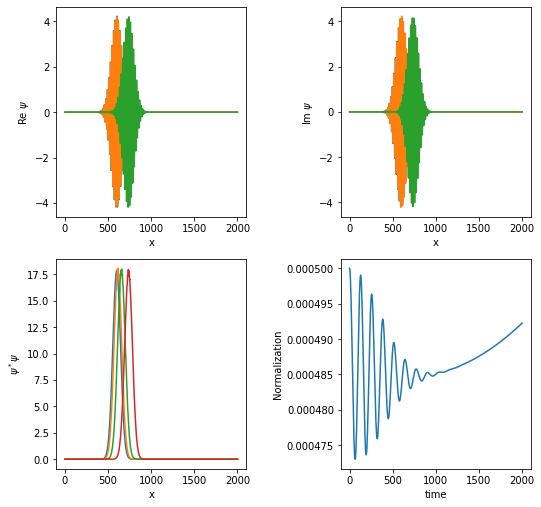

In [2]:
import matplotlib.pyplot as plt
import numpy as np

dt = 0.0000001
dx = 0.0005
tot_steps = 2000
sig_sqr = 0.0005
x0 = 0.3
k0 = 700
C = 1.0/(2.0*np.pi*sig_sqr)**0.25
print("norm: \n", C)
dt_dx = dt/(2.0*dx**2)
print("dt_dx: \n", dt_dx)


# total domain
L = 1.0
#number of x grid points
Nx = int(L/dx)

#initialize our array. timesteps are the rows, x grid points are the columns
Re = [[0.0 for j in range(0,Nx+2)] for i in range(0,tot_steps+1)]
Im = [[0.0 for j in range(0,Nx+2)] for i in range(0,tot_steps+1)]
psi_sqr = [[0.0 for j in range(0,Nx+2)] for i in range(0,tot_steps+1)]

#I'll use this to store the normalization of the wf (sum over all the grid points
# psi*psi) to check whether it stays normalized...like checking 
norm = []
expect_x = []
expect_x2 = []
psi_sig_sqr = []


#initialize the wavefunction
total = 0
x_total = 0
x2_total = 0
#try changing range and using the midpoint of each bin for x?
for j in range(0,Nx+1):
    x = j*dx
    #Re[0][j] = norm*np.exp((-(x-x0)**2)/(sig_sqr))
    Re[0][j] = C*np.cos(k0*(x-x0))*np.exp((-(x-x0)**2)/(4.0*sig_sqr))
    Im[0][j] = C*np.sin(k0*(x-x0))*np.exp((-(x-x0)**2)/(4.0*sig_sqr))
    psi_sqr[0][j] = Re[0][j]*Re[0][j] + Im[0][j]*Im[0][j]
    # integrate to get the normalization. note that you have to multiply by dx
    total = total + dx*psi_sqr[0][j]
    x_total = x_total + dx*x*psi_sqr[0][j]
    x2_total = x2_total + dx*x*x*psi_sqr[0][j]

# add the current normalization to the list   
norm.append(total)
expect_x.append(x_total)
expect_x2.append(x2_total)
tmp = x2_total - x_total*x_total
psi_sig_sqr.append(tmp)

#now the leapfrog loop
for i in range(1,tot_steps):
    #print("STEP: \n", i)
    Im[i][0] = 0.0 
    Im[i][Nx+1] = 0.0
    Re[i][0] = 0.0
    Re[i][Nx+1] = 0.0
    for j in range(1,Nx):
        Im[i][j] = Im[i-1][j] + dt_dx*(Re[i-1][j+1] -2.0*Re[i-1][j] + Re[i-1][j-1])
    total = 0
    x_total = 0
    x2_total = 0
    for j in range(1,Nx):
        x = j*dx
        #print("Re loop j:", j)
        Re[i][j] = Re[i-1][j] - dt_dx*(Im[i][j+1] -2.0*Im[i][j] + Im[i][j-1])
        psi_sqr[i][j] = Re[i][j]*Re[i][j] + Im[i][j]*Im[i][j]
        total = total + dx*psi_sqr[i][j]
        x_total = x_total + dx*x*psi_sqr[i][j]
        x2_total = x2_total + dx*x*x*psi_sqr[i][j]
    norm.append(total)
    expect_x.append(x_total)
    expect_x2.append(x2_total)
    tmp = x2_total - x_total*x_total
    psi_sig_sqr.append(tmp)

plt.figure(1, figsize=(8.5, 8.5))
plt.subplots_adjust(wspace=0.5)
    
plt.figure(1, figsize=(10, 3))
plt.subplots_adjust(wspace=0.5)
ax = plt.subplot(221)
ax.set_xlabel('x')
ax.set_ylabel('Re $\psi$')
#ax.set_xlim(right=650)
#ax.set_xlim(left=550)
plt.plot(Re[0])
plt.plot(Re[10])
plt.plot(Re[999])
#plt.plot(Re[13])
#plt.plot(Re[400])

ax2 = plt.subplot(222)
ax2.set_xlabel('x')
ax2.set_ylabel('Im $\psi$')
#ax2.set_xlim(right=650)
#ax2.set_xlim(left=550)
#ax2.set_xlim(right=40)
plt.plot(Im[0])
plt.plot(Im[10])
plt.plot(Im[999])
#plt.plot(Im[13])
#plt.plot(Im[400])


ax3 = plt.subplot(223)
ax3.set_xlabel('x')
ax3.set_ylabel('$\psi^*\psi$')
#ax3.set_xlim(right=1050)
#ax3.set_xlim(left=950)
#ax2.set_xlim(right=40)
plt.plot(psi_sqr[0])
plt.plot(psi_sqr[99])
plt.plot(psi_sqr[400])
plt.plot(psi_sqr[999])

ax4 = plt.subplot(224)
ax4.set_xlabel('time')
ax4.set_ylabel('Normalization')
#ax2.set_xlim(right=1100)
#ax4.set_xlim(right=500)
#ax2.set_xlim(right=40)
#plt.plot(Im[999])
#plt.plot(norm)
#plt.plot(expect_x)
#plt.plot(expect_x2)
plt.plot(psi_sig_sqr)


plt.show()
